By directly comparing the UVF_weights of [FHD](https://github.com/EoRImaging/FHD)+[$\epsilon$](https://github.com/EoRImaging/eppsilon) output and the UV coverage (uvf_cube) created by this package, we can establish the extent to which the py21cmwedge UV_coverage estimation recovers the shape of uv_weights predicted by the FHD+$\epsilon$ software.

This, along with a correlation between the shape of the uv_weights and the total power between the FoV of and instrument and the horizon, can be used to form a statistic to judge the extent to which an array can expect Foreground leakage in the wedge from an imaging analysis.

In [6]:
%matplotlib notebook
import numpy as np
import healpy as hp
from matplotlib.pyplot import *
import matplotlib.ticker as ticker
from astropy.io import fits
from matplotlib.colors import SymLogNorm, LogNorm
from py21cmwedge import UVGridder, cosmo, dft
from scipy.io import readsav
import glob
# filename='/home/mkolopanis/src/PRISim/prisim/data/beams/HERA_HFSS_X4Y2H_4900.hmap'
filename='/home/mkolopanis/fhd_wedge_power/FHD_beam_x.fits'

The following function is useful to count the number of redudant baselines up to a "precision factor." Taken from [HERA-TEAM/hera_cal/redcal.py](https://github.com/HERA-Team/hera_cal/blob/master/hera_cal/redcal.py)

In [7]:
def get_reds(antpos, precisionFactor=1000000):
    """Returns an list of lists of tuples representing redundancies. Ordered by length. All baselines have the same 
    orientation with a preference for positive b_y and, when b_y==0, positive b_x where b((i,j)) = pos(i) - pos(j)."""
    keys = antpos.keys()
    reds = {}
    for i,ant1 in enumerate(keys):
        for ant2 in keys[i+1:]:
            delta = tuple((precisionFactor * (np.array(antpos[ant1]) - np.array(antpos[ant2]))).astype(int))
            if delta[1] > 0 or (delta[1]==0 and delta[0] > 0):
                if reds.has_key(delta): reds[delta] += [(ant1,ant2)]
                else: reds[delta] = [(ant1,ant2)]
            else:
                delta = tuple([-d for d in delta])
                if reds.has_key(delta): reds[delta] += [(ant2,ant1)]
                else: reds[delta] = [(ant2,ant1)]
    orderedDeltas = [delta for (delta,length) in sorted(zip(reds.keys(), [np.linalg.norm(delta) for delta in reds.keys()]))]
    return [reds[delta] for delta in orderedDeltas]

In [8]:
def rotate_map(hmap, rot=None, deg=False, **kwargs):
    """
    Take hmap (a healpix map array) and return another healpix map array 
    which is ordered such that it has been rotated in (theta, phi) by the 
    amounts given.
    """
    nside = hp.npix2nside(len(hmap))

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))) #theta, phi

    # Define a rotator
    r = hp.Rotator(deg=deg, rot=rot, **kwargs)

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)

    # Interpolate map onto these co-ordinates
    rot_map = hp.get_interp_val(hmap, trot, prot)

    return rot_map

In [9]:
# Load the HFSS beam simulation of a HERA dish
beam = fits.getdata(filename, 'BEAM_X')
freqs = fits.getdata(filename, 'FREQS_X')
ind = np.argmin(abs(freqs-150e6))
beam_150 = beam[:,ind]
freq = 150e6
redshift = 1420e6/freq - 1

In [102]:
# Load up the HERA_37 FHD + Eppsilon output weights cube
weight_list = glob.glob('/home/mkolopanis/fhd_wedge_power/fhd_hera_37_6sep/ps/*weights_uvf*.idlsave')
weight_filename = weight_list.pop()
weight_file = readsav(weight_filename)

kx = weight_file.kx_rad_vals/cosmo.comoving_distance(redshift)
ky = weight_file.ky_rad_vals/cosmo.comoving_distance(redshift)
weights_cube = weight_file.weights_cube

fhd_us = cosmo.kperp2u(kx,8.47)
fhd_ind = weights_cube.shape[0]/2

In [103]:
delta_u = np.diff(fhd_us)[0]
print delta_u

0.736987187589


In [105]:
new_beam= rotate_map(beam_150, [np.pi/2,0,0], deg=False)
new_beam= rotate_map(new_beam, [0,np.pi/(12*3600) *330 * 2,0], deg=False)
uv_beam = dft.hpx_to_uv(new_beam*new_beam.conj(), delta_u)
uv_beam /= uv_beam.sum() 
inds = np.argwhere(np.abs(uv_beam) <= np.abs(uv_beam).max()/10)
uv_beam[inds[:,0], inds[:,1]] = 0

In [106]:
# Set up the UVGridder object for HERA 37
gridder = UVGridder()
gridder.set_uv_delta(delta_u) # Size of pixel in the UV plane (in wavelengths)
# gridder.set_beam(beam_150)
gridder.set_uv_beam(uv_beam)
gridder.read_antpos('/home/mkolopanis/hera_sims/hera_layouts/antenna_positions_37.dat', skiprows=1)
gridder.set_freqs(freq)
gridder.calc_all()
us_grid = np.arange(gridder.uv_size).astype(np.float64) - (gridder.uv_size -1)/2
us_grid *= gridder.uv_delta
ks_grid = cosmo.u2kperp(us_grid, redshift)

But we know that PRISim only outputs 1 copy of each redundant baseline type,
so we should recalculate the uvf_cube from py21cmwedge in a Uniform weighting scenario:

In [110]:
new_dict = {}
for key in gridder.uvbins:
    new_dict[key] = [gridder.uvbins[key][0]]

In [111]:
import copy
new_gridder = copy.copy(gridder)
new_gridder.uvbins = new_dict
new_gridder.grid_uvw()

In [112]:
fhd_us_ind = np.logical_and(kx > .01, kx < .04)
ks_ind = np.logical_and(ks_grid > .01, ks_grid < .04)

<IPython.core.display.Javascript object>


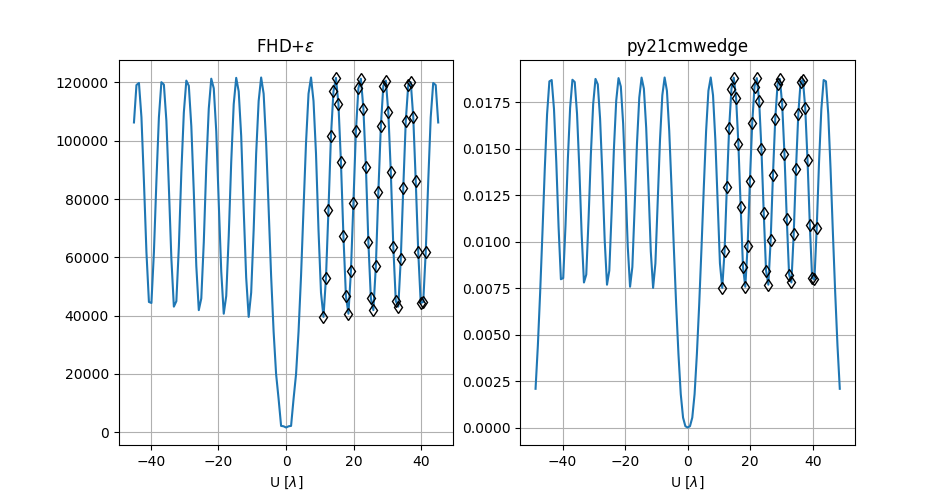

In [114]:
fig, axes = subplots(ncols=2, figsize=(9.5,5))
# for i in range(axes.size):
#     axes[i].xaxis.set_major_locator(ticker.MultipleLocator(.1))
    
axes[0].plot(fhd_us, np.abs(weights_cube[fhd_ind, 0, :]))
axes[0].plot(fhd_us[fhd_us_ind], np.abs(weights_cube[fhd_ind, 0, :])[fhd_us_ind], 'kd', mfc='none')

axes[0].grid()
# axes[0].set_xlim([-.5,.5])
axes[0].set_title("FHD+$\epsilon$")
axes[0].set_xlabel('U [$\lambda$]')

axes[1].plot(us_grid, np.abs(new_gridder.uvf_cube[0,(new_gridder.uv_size -1)/2]))
axes[1].plot(us_grid[ks_ind], np.abs(new_gridder.uvf_cube[0,(new_gridder.uv_size -1)/2])[ks_ind],
             'kd', mfc='none')

axes[1].grid()
# axes[1].yaxis.set_major_locator(ticker.MultipleLocator(.01))
# axes[1].set_xlim({-.5,.5})
axes[1].set_title('py21cmwedge')
axes[1].set_xlabel('U [$\lambda$]')

The proposed statistic we wish to use to indicate the amount of wedge leakage is the Standard devation of the weights cube divided by its mean over an arbitrarily chosen k-bin.

For an example we will consider all the k_values in the range $.05 < k < .5$ in $h$Mpc$^{-1}$

In [115]:
fhd_mean = np.mean(np.abs(weights_cube[fhd_ind, 0])[fhd_us_ind])
fhd_std = np.std(np.abs(weights_cube[fhd_ind, 0])[fhd_us_ind])
wedge_mean = np.mean(np.abs(new_gridder.uvf_cube[0,(new_gridder.uv_size -1)/2])[ks_ind])
wedge_std = np.std(np.abs(new_gridder.uvf_cube[0,(new_gridder.uv_size -1)/2])[ks_ind])


print "Simulation\tMean\t\tStd\t\tStd/Mean"
print "FHD        \t{0:.3e}\t{1:.3e}\t{2:.3e}".format(fhd_mean, fhd_std, fhd_std/fhd_mean)
print "Py21cmwedge\t{0:.3e}\t{1:.3e}\t{2:.3e}".format(wedge_mean, wedge_std, wedge_std/wedge_mean)

Simulation	Mean		Std		Std/Mean
FHD        	8.169e+04	2.867e+04	3.510e-01
Py21cmwedge	1.346e-02	3.985e-03	2.962e-01


The PRISim simulation also contains rotation synthesis over 660s made in 60s time intervals

We can also produce these effects using py21cmwedge's simulation_observation function

In [116]:
new_uvw_array = []

for key in new_dict:
    _u,_v = map(float, key.split(','))
    new_uvw_array.append([_u,_v,0])

new_uvw_array= np.unique(new_uvw_array,axis=0)

In [117]:
synth_gridder = copy.copy(gridder)
synth_gridder.set_uvw_array(new_uvw_array)
synth_gridder.set_latitude( -30.7224 * np.pi/180)
synth_gridder.set_t_int(11)
synth_gridder.set_n_obs(60)
synth_gridder.calc_all()

<IPython.core.display.Javascript object>


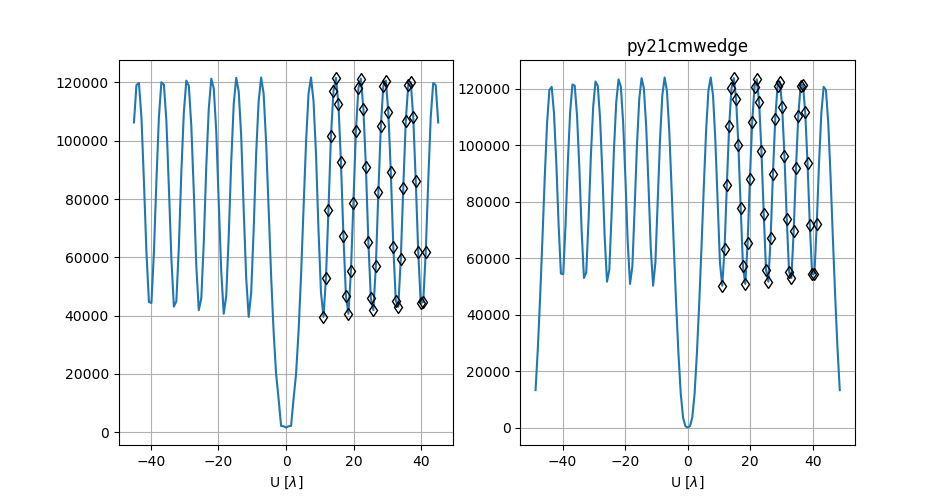

In [118]:
newfig, axes = subplots(ncols=2, figsize=(9.5,5))
# for i in range(axes.size):
#     axes[i].xaxis.set_major_locator(ticker.MultipleLocator(.1))
norm = np.abs(weights_cube[fhd_ind]).max()/np.abs(synth_gridder.uvf_cube[0]).max()
    
axes[0].plot(fhd_us, np.abs(weights_cube[fhd_ind, 0, :]))
axes[0].plot(fhd_us[fhd_us_ind], np.abs(weights_cube[fhd_ind, 0, :])[fhd_us_ind], 'kd', mfc='none')

axes[0].grid()
# axes[0].set_xlim([-.5,.5])
# axes[0].set_title("FHD+$\epsilon$")
axes[0].set_xlabel('U [$\lambda$]')

axes[1].plot(us_grid, np.abs(synth_gridder.uvf_cube[0,(synth_gridder.uv_size -1)/2])*norm)
axes[1].plot(us_grid[ks_ind], np.abs(synth_gridder.uvf_cube[0,(synth_gridder.uv_size -1)/2])[ks_ind]*norm,
             'kd', mfc='none')

axes[1].grid()
# axes[1].yaxis.set_major_locator(ticker.MultipleLocator(.01))
# axes[1].set_xlim({-.5,.5})
axes[1].set_title('py21cmwedge')
axes[1].set_xlabel('U [$\lambda$]')

In [119]:
fhd_mean = np.mean(np.abs(weights_cube[fhd_ind, 0])[fhd_us_ind])
fhd_std = np.std(np.abs(weights_cube[fhd_ind, 0])[fhd_us_ind])
wedge_mean = np.mean(np.abs(synth_gridder.uvf_cube[0,(synth_gridder.uv_size -1)/2])[ks_ind])
wedge_std = np.std(np.abs(synth_gridder.uvf_cube[0,(synth_gridder.uv_size -1)/2])[ks_ind])


print "Simulation\tMean\t\tStd\t\tStd/Mean"
print "FHD        \t{0:.3e}\t{1:.3e}\t{2:.3e}".format(fhd_mean, fhd_std, fhd_std/fhd_mean)
print "Py21cmwedge\t{0:.3e}\t{1:.3e}\t{2:.3e}".format(wedge_mean, wedge_std, wedge_std/wedge_mean)

Simulation	Mean		Std		Std/Mean
FHD        	8.169e+04	2.867e+04	3.510e-01
Py21cmwedge	8.081e-01	2.331e-01	2.884e-01
